<a href="https://colab.research.google.com/github/sinamedialab/earthquakesmartspace/blob/master/risk_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earthquake Risk Analysis 

The risk of each single object can be calculated using the following equation:

$risk = size \times (weight \times (moving +  falling) +  (spreading \times type))$



,count,risk
object,,
backpack,0,1.799680
handbag,0,0.438533
suitcase,0,2.071438
bottle,0,0.165888
wine glass,0,0.029519
cup,0,0.022253
bowl,0,0.040998
chair,6,0.378623
couch,0,0.352484


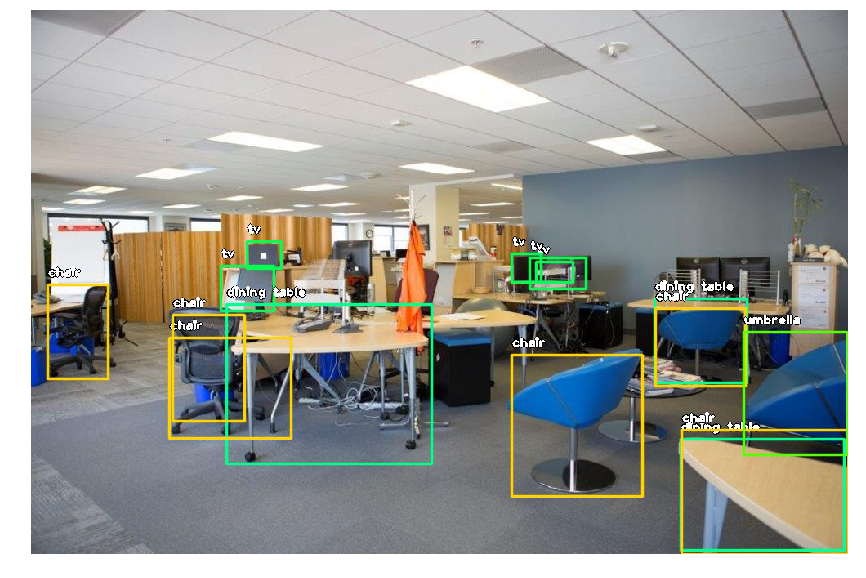

In [3]:
import sys
import os
import time
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import urllib.request
from urllib.request import urlretrieve

#Downloader settings
opener=urllib.request.build_opener()
opener.addheaders=[('User-Agent',
                    'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
urllib.request.install_opener(opener)

%matplotlib inline


#Install imageai if not installed
if not('imageai' in sys.modules):
  !pip3 install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl

from imageai.Detection import ObjectDetection    

#Download detector if not exist
resnet50_coco_best_url = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5'
yolo_detector_url = 'https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5'
yolo_tiny_url = 'https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo-tiny.h5'

detector_models = {'resnet50_coco_best.h5': resnet50_coco_best_url,
                   'yolo.h5':yolo_detector_url,
                   'yolo-tiny.h5':yolo_tiny_url
                  }

detector_name = 'yolo.h5'
exists = os.path.isfile(detector_name)
if not(exists):
  urlretrieve(detector_models[detector_name],detector_name)
    
#Download risk featutre for known objects if not exist
risk_url = 'https://raw.githubusercontent.com/sinamedialab/earthquakesmartspace/master/object_risk.csv'
risk_csv_name = 'object_risk.csv'
exists = os.path.isfile(risk_csv_name)
if not(exists):
  urlretrieve(risk_url,risk_csv_name)

#Time and path of execution
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
execution_path = os.getcwd()

#Set your own image file url
img_url = 'https://media.glassdoor.com/l/a1/65/ab/b0/our-office.jpg'
#img_url = 'http://dreamstop.com/wp-content/uploads/2013/07/office-dream-meaning.jpeg'
img_ext = '.jpg'
input_img_name = 'input-'+now+img_ext

urlretrieve(img_url,input_img_name)
input_image = input_img_name
object_risk_df = pd.read_csv(risk_csv_name)
detector_model = detector_name

#Object detector settings
input_image_path = os.path.join(execution_path , input_image)
output_image_path=os.path.join(execution_path , 'input-'+now+'-detected'+img_ext)
mpp=20
detector = ObjectDetection()
if (detector_name == 'yolo.h5'):
  detector.setModelTypeAsYOLOv3()
elif(detector_name == 'yolo-tiny.h5'):
  detector.setModelTypeAsTinyYOLOv3()
else:
  detector.setModelTypeAsRetinaNet()


detector.setModelPath( os.path.join(execution_path , detector_model))
detector.loadModel()

#Run object detection on input_image and save result as out_image
start_time = time.time()  
detections = detector.detectObjectsFromImage(input_image=input_image_path, 
                                             output_image_path=output_image_path,
                                             display_percentage_probability=False,
                                             display_object_name=True,
                                             minimum_percentage_probability=mpp)   
elapsed_time_secs = round(time.time() - start_time)


# Risk calculation equation
def risk_calc(obj):
  size = obj['size']
  weight = obj['weight']
  moving = obj['moving']
  falling = obj['falling']
  spreading = obj['spreading']
  obj_type = obj['type']
  return size * (weight * (moving +  falling) +  (spreading * obj_type))

#Load risk dataframe
object_risk_df = pd.read_csv('object_risk.csv')
object_risk_df.index = object_risk_df['object']

#Create Report dataframe for objects WITH risk features
report_df = pd.DataFrame()
report_df['object'] = object_risk_df['object']
report_df.index = object_risk_df['object']
report_df['count']=0
report_df['risk'] = object_risk_df.apply(lambda obj: risk_calc(obj), axis = 1)
report_df.drop(['object'], axis = 1, inplace = True)

#Create Report dataframe for objects WITHOUT risk features
report_no_risk_object_df = pd.DataFrame()
report_no_risk_object_df.index.name = 'no_risk_objects'


#Count the number of objects for both objects with and without risk features
for eachObject in detections:
  if (eachObject["name"] in list(object_risk_df['object'])):
    report_df.loc[eachObject["name"],'count']+=1
  else:
    if eachObject["name"] in report_no_risk_object_df.index:
      report_no_risk_object_df.loc[eachObject["name"],'count']+=1
    else:
      report_no_risk_object_df.loc[eachObject["name"],'count'] =1
      

#Display results
plt.figure(figsize = (15,10))
plt.axis('off')
img = mpimg.imread(output_image_path)
imgplot = plt.imshow(img)

      
#Prepare report for objects WITH risk features
if len(report_df)>0:
  if ('Total' in report_df.index):
    report_df.drop(['Total'], axis = 0, inplace = True)
  report_df.loc['Total', 'count'] = report_df['count'].sum()
  report_df.loc['Total', 'risk'] = (report_df.apply(lambda row: row['count']*row['risk'], axis = 1)).sum()
  report_df.loc['Detection Time (s)', 'count'] = elapsed_time_secs;
  report_df['count'] = report_df['count'].astype(np.int32)
  report_file = input_image+"-" + now + '-report.csv'
  report_df.to_csv(report_file)

#Prepare report for objects WITHOUT risk features
if len(report_no_risk_object_df)>0:
  if ('Total' in report_no_risk_object_df.index):
    report_no_risk_object_df.drop(['Total'], axis = 0, inplace = True)
  report_no_risk_object_df.loc['Total', 'count'] = report_no_risk_object_df['count'].sum()
  report_no_risk_object_df['count'] = report_no_risk_object_df['count'].astype(np.int32)
  report_file = input_image+"-" + now + '-no-risk-report.csv'
  report_no_risk_object_df.to_csv(report_file)

report_df